In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#change filename here if necessary
filename = 'Desktop\AAPL (3).csv'

df = pd.read_csv(filename)

df.sort_values('Date')

df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
4517,2018-08-31,226.509995,228.869995,226.000000,227.630005,227.630005,43340100
4518,2018-09-04,228.410004,229.179993,226.630005,228.360001,228.360001,27390100
4519,2018-09-05,228.990005,229.669998,225.100006,226.869995,226.869995,33333000
4520,2018-09-06,226.229996,227.350006,221.300003,223.100006,223.100006,34290000
4521,2018-09-07,221.850006,225.369995,220.710007,221.300003,221.300003,37619800
4522,2018-09-10,220.949997,221.850006,216.470001,218.330002,218.330002,39516500
4523,2018-09-11,218.009995,224.300003,216.559998,223.850006,223.850006,35749000
4524,2018-09-12,224.940002,225.000000,219.839996,221.070007,221.070007,49278700
4525,2018-09-13,223.520004,228.350006,222.570007,226.410004,226.410004,41706400
4526,2018-09-14,225.750000,226.839996,222.520004,223.839996,223.839996,31902700


In [2]:
#taking  the low and high price columns here
low_prices = df.loc[:,'Low'].as_matrix()
high_prices = df.loc[:,'High'].as_matrix()

low_prices

C:\Users\Yi Rong\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Yi Rong\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([  3.933036,   4.183036,   4.183036, ..., 219.839996, 222.570007,
       222.520004])

In [4]:
#setting number of inputs in a sliding window to produce number of days of outputs. 
#Here 504 days corresponding to 2 years of trading days is used to produce 120 days of output data
sliding_window = 504
future_spacing = 120

low_scaled = low_prices[:(len(low_prices)-future_spacing)].copy()
high_scaled = high_prices[:len(high_prices)-future_spacing].copy()

X_input_low = []
Y_output_low = []

X_input_high = []
Y_output_high = []

#Here we normalize each sliding window input and output by dividing every entry with the mean of the previous sliding window
#Every element in each of the X inputs is an array of 504 data points, and each element in a Y output is an array of 120 points

for i in range(sliding_window, len(low_scaled)-sliding_window-future_spacing, 1):
    sliding_x = low_scaled[i:i+sliding_window]
    prev_window_avg = low_scaled[i-sliding_window:i].mean()
    sliding_window_x = [k/prev_window_avg for k in sliding_x]
    X_input_low.append(sliding_window_x)
    
for i in range(2*sliding_window, len(low_scaled)-future_spacing, 1):
    sliding_y = low_scaled[i:i+future_spacing]
    prev_window_avg = low_scaled[i-sliding_window:i].mean()
    sliding_window_y = [k/prev_window_avg for k in sliding_y]
    Y_output_low.append(sliding_window_y)

for i in range(sliding_window, len(high_scaled)-sliding_window- future_spacing, 1):
    sliding_x2 = high_scaled[i:i+sliding_window]
    prev_window_avg2 = high_scaled[i-sliding_window:i].mean()
    sliding_window_x2 = [k/prev_window_avg2 for k in sliding_x2]
    X_input_high.append(sliding_window_x2)
    
for i in range(2*sliding_window, len(low_scaled)-future_spacing, 1):
    sliding_y = low_scaled[i:i+future_spacing]
    prev_window_avg = low_scaled[i-sliding_window:i].mean()
    sliding_window_y = [k/prev_window_avg for k in sliding_y]
    Y_output_high.append(sliding_window_y)

print(len(X_input_low))
print (len(Y_output_low))
print(len(X_input_high))
print(len(Y_output_high))

train_length = len(X_input_low)

3279
3279
3279
3279


In [5]:
#Reshaping the above arrays to feed into the LSTM model

X_input_low = np.array(X_input_low)
Y_output_low = np.array(Y_output_low)
X_input_low = X_input_low.reshape(len(X_input_low),sliding_window,1)
Y_output_low = Y_output_low.reshape(len(Y_output_low),future_spacing)


X_input_high = np.array(X_input_high)
Y_output_high = np.array(Y_output_high)
X_input_high = X_input_high.reshape(len(X_input_high),sliding_window,1)
Y_output_high = Y_output_high.reshape(len(Y_output_high),future_spacing)

In [6]:
#training the model

val_cutoff = int(0.9*train_length)
X_train_low = X_input_low[:val_cutoff]
X_test_low = X_input_low[val_cutoff:]

Y_train_low = Y_output_low[:val_cutoff]
Y_test_low = Y_output_low[val_cutoff:]

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dropout
from keras import optimizers



model = Sequential()
model.add(LSTM(units= 256,input_shape=(sliding_window, 1), return_sequences=False))
#model.add(LSTM(units= 64, activation = 'relu'))
#Dropout(rate = 0.5)
model.add(Dense(units = future_spacing,activation = 'relu'))
#Dropout(rat = 0.5)
model.add(Dense(units = future_spacing))
#optimizer = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile( loss='mean_squared_error', optimizer= 'adam')
model.fit(X_train_low, Y_train_low, batch_size=128, epochs=200, validation_data = (X_test_low, Y_test_low),verbose = 1)



Using TensorFlow backend.


Train on 2951 samples, validate on 328 samples
Epoch 1/200
2951/2951 [==============================] - 29s 10ms/step - loss: 1.2715 - val_loss: 0.1175
Epoch 2/200
2951/2951 [==============================] - 25s 8ms/step - loss: 0.2639 - val_loss: 0.1557
Epoch 3/200
2951/2951 [==============================] - 25s 8ms/step - loss: 0.2333 - val_loss: 0.0241
Epoch 4/200
2951/2951 [==============================] - 24s 8ms/step - loss: 0.2121 - val_loss: 0.0279
Epoch 5/200
2951/2951 [==============================] - 25s 8ms/step - loss: 0.2152 - val_loss: 0.0170
Epoch 6/200
2951/2951 [==============================] - 24s 8ms/step - loss: 0.2069 - val_loss: 0.0488
Epoch 7/200
2951/2951 [==============================] - 25s 8ms/step - loss: 0.2076 - val_loss: 0.0270
Epoch 8/200
2951/2951 [==============================] - 24s 8ms/step - loss: 0.2031 - val_loss: 0.0101
Epoch 9/200
2951/2951 [==============================] - 25s 8ms/step - loss: 0.2043 - val_loss: 0.0803
Epoch 10/200
295

2951/2951 [==============================] - 22s 8ms/step - loss: 0.1269 - val_loss: 0.0172
Epoch 79/200
2951/2951 [==============================] - 22s 8ms/step - loss: 0.0965 - val_loss: 0.0317
Epoch 80/200
2951/2951 [==============================] - 23s 8ms/step - loss: 0.0871 - val_loss: 0.0179
Epoch 81/200
2951/2951 [==============================] - 23s 8ms/step - loss: 0.0839 - val_loss: 0.0360
Epoch 82/200
2951/2951 [==============================] - 22s 7ms/step - loss: 0.1157 - val_loss: 0.0221
Epoch 83/200
2951/2951 [==============================] - 23s 8ms/step - loss: 0.1077 - val_loss: 0.0245
Epoch 84/200
2951/2951 [==============================] - 23s 8ms/step - loss: 0.0970 - val_loss: 0.0207
Epoch 85/200
2951/2951 [==============================] - 22s 8ms/step - loss: 0.0836 - val_loss: 0.0233
Epoch 86/200
2951/2951 [==============================] - 22s 7ms/step - loss: 0.2138 - val_loss: 0.0237
Epoch 87/200
2951/2951 [==============================] - 25s 8ms/st

2951/2951 [==============================] - 24s 8ms/step - loss: 0.0535 - val_loss: 0.0395
Epoch 156/200
2951/2951 [==============================] - 23s 8ms/step - loss: 0.0666 - val_loss: 0.0304
Epoch 157/200
2951/2951 [==============================] - 23s 8ms/step - loss: 0.0531 - val_loss: 0.0088
Epoch 158/200
2951/2951 [==============================] - 22s 8ms/step - loss: 0.0498 - val_loss: 0.0291
Epoch 159/200
2951/2951 [==============================] - 23s 8ms/step - loss: 0.0572 - val_loss: 0.0296
Epoch 160/200
2951/2951 [==============================] - 22s 8ms/step - loss: 0.0563 - val_loss: 0.0101
Epoch 161/200
2951/2951 [==============================] - 23s 8ms/step - loss: 0.0515 - val_loss: 0.0319
Epoch 162/200
2951/2951 [==============================] - 23s 8ms/step - loss: 0.0482 - val_loss: 0.0142
Epoch 163/200
2951/2951 [==============================] - 23s 8ms/step - loss: 0.0468 - val_loss: 0.0132
Epoch 164/200
2951/2951 [==============================] - 2

In [7]:
#Using last 504 days of data to produce 120 days of outputs

last_window_low = low_scaled[-sliding_window:]
prev_window_avglow = low_scaled[-2*sliding_window:-sliding_window].mean()
last_window_avglow = last_window_low.mean()
low_values = [k/prev_window_avglow for k in last_window_low]
low_values = np.array(low_values)
low_values = low_values.reshape(1,-1,1)

predicted_norm_low = model.predict(low_values)

predicted_denorm_low = []
for x in predicted_norm_low:
    x_denorm = last_window_avglow*x
    predicted_denorm_low.append(x_denorm)
    
predicted_denorm_low = np.array(predicted_denorm_low)
four_month_predictions_low = predicted_denorm_low.reshape(120,1)
len(four_month_predictions_low)

120

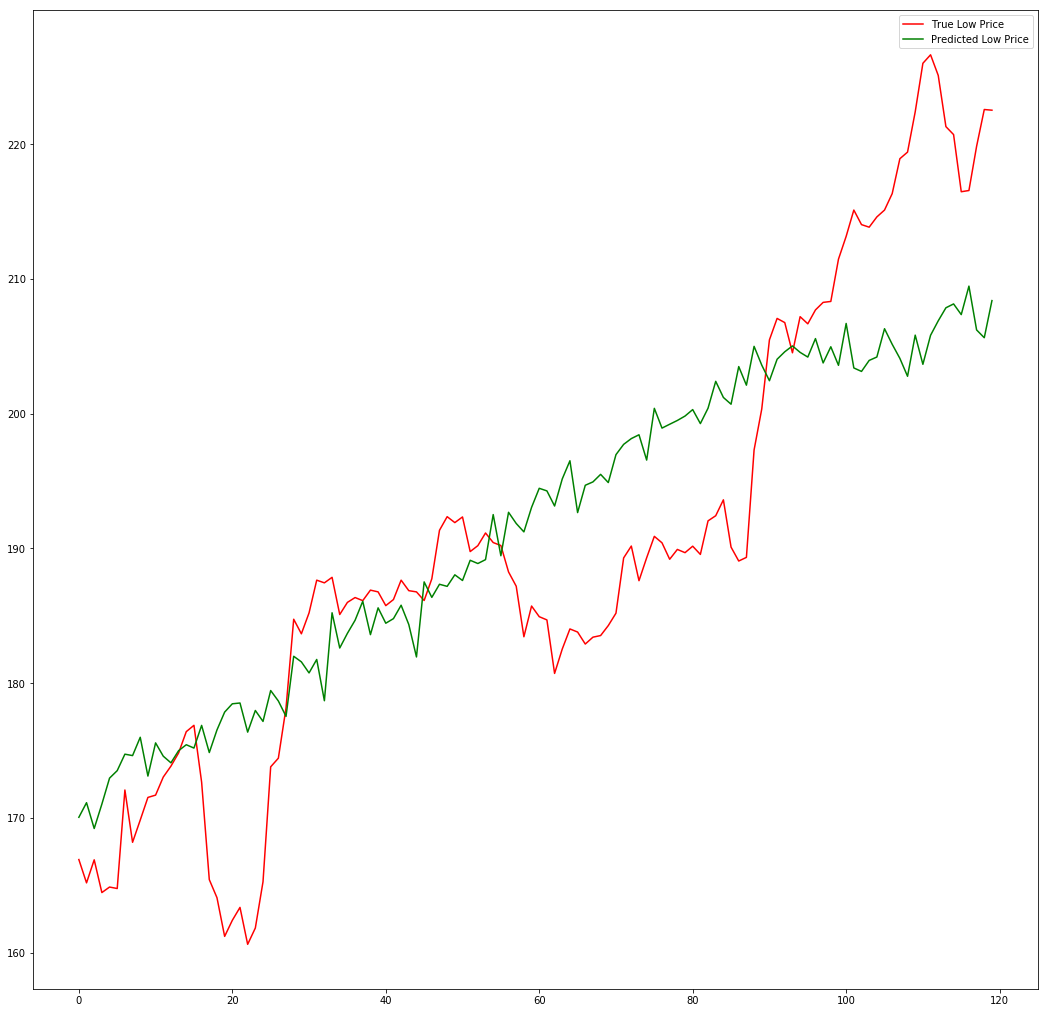

In [8]:
plt.figure(figsize = (18,18))
plt.plot(low_prices[(len(low_prices)-future_spacing):], color = 'red', label = 'True Low Price')
plt.plot(four_month_predictions_low, color = 'green', label = 'Predicted Low Price')
plt.legend()
plt.show()

In [16]:
#training the model

val_cutoff = int(0.9*train_length)
X_train_high = X_input_high[:val_cutoff]
X_test_high = X_input_high[val_cutoff:]

Y_train_high = Y_output_high[:val_cutoff]
Y_test_high = Y_output_high[val_cutoff:]

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dropout
from keras import optimizers



model = Sequential()
model.add(LSTM(units= 256,input_shape=(sliding_window, 1), return_sequences=False))
#model.add(LSTM(units= 64, activation = 'relu'))
#Dropout(rate = 0.5)
model.add(Dense(units = future_spacing,activation = 'relu'))
#Dropout(rat = 0.5)
model.add(Dense(units = future_spacing))
#optimizer = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile( loss='mean_squared_error', optimizer= 'adam')
model.fit(X_train_high, Y_train_high, batch_size=256, epochs=100, validation_data = (X_test_high, Y_test_high),verbose = 1)



Train on 2951 samples, validate on 328 samples
Epoch 1/100
2951/2951 [==============================] - 14s 5ms/step - loss: 2.0540 - val_loss: 0.5913
Epoch 2/100
2951/2951 [==============================] - 13s 4ms/step - loss: 0.6788 - val_loss: 0.1143
Epoch 3/100
2951/2951 [==============================] - 13s 4ms/step - loss: 0.2810 - val_loss: 0.0396
Epoch 4/100
2951/2951 [==============================] - 13s 4ms/step - loss: 0.2367 - val_loss: 0.0301
Epoch 5/100
2951/2951 [==============================] - 13s 4ms/step - loss: 0.2173 - val_loss: 0.0386
Epoch 6/100
2951/2951 [==============================] - 13s 5ms/step - loss: 0.2123 - val_loss: 0.0359
Epoch 7/100
2951/2951 [==============================] - 14s 5ms/step - loss: 0.2097 - val_loss: 0.0116
Epoch 8/100
2951/2951 [==============================] - 13s 4ms/step - loss: 0.2085 - val_loss: 0.0388
Epoch 9/100
2951/2951 [==============================] - 12s 4ms/step - loss: 0.2077 - val_loss: 0.0205
Epoch 10/100
2951

2951/2951 [==============================] - 13s 4ms/step - loss: 0.0773 - val_loss: 0.0155
Epoch 79/100
2951/2951 [==============================] - 13s 4ms/step - loss: 0.0762 - val_loss: 0.0096
Epoch 80/100
2951/2951 [==============================] - 13s 4ms/step - loss: 0.0716 - val_loss: 0.0131
Epoch 81/100
2951/2951 [==============================] - 13s 4ms/step - loss: 0.0703 - val_loss: 0.0081
Epoch 82/100
2951/2951 [==============================] - 13s 4ms/step - loss: 0.0693 - val_loss: 0.0116
Epoch 83/100
2951/2951 [==============================] - 13s 4ms/step - loss: 0.0708 - val_loss: 0.0092
Epoch 84/100
2951/2951 [==============================] - 13s 4ms/step - loss: 0.0624 - val_loss: 0.0095
Epoch 85/100
2951/2951 [==============================] - 13s 4ms/step - loss: 0.0582 - val_loss: 0.0102
Epoch 86/100
2951/2951 [==============================] - 13s 4ms/step - loss: 0.0541 - val_loss: 0.0091
Epoch 87/100
2951/2951 [==============================] - 13s 4ms/st

In [17]:
#Using last 504 days of data to produce 120 days of outputs

last_window_high = high_scaled[-sliding_window:]
prev_window_avghigh = high_scaled[-2*sliding_window:-sliding_window].mean()
last_window_avghigh = last_window_high.mean()
high_values = [k/prev_window_avghigh for k in last_window_high]
high_values = np.array(high_values)
high_values = high_values.reshape(1,-1,1)

predicted_norm_high = model.predict(high_values)

predicted_denorm_high = []
for x in predicted_norm_high:
    x_denorm = last_window_avghigh*x
    predicted_denorm_high.append(x_denorm)
    
predicted_denorm_high = np.array(predicted_denorm_high)
four_month_predictions_high = predicted_denorm_high.reshape(120,1)
len(four_month_predictions_high)

120

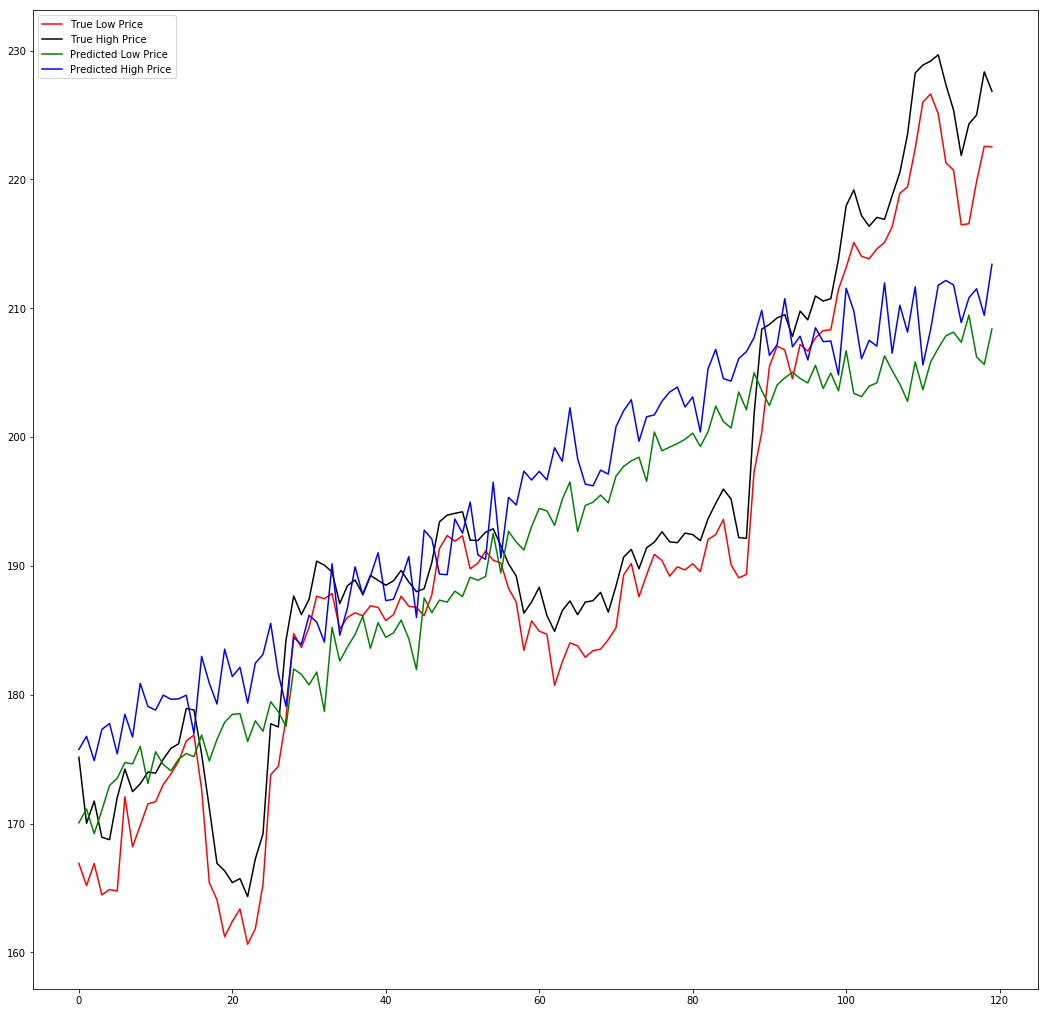

In [23]:
plt.figure(figsize = (18,18))
plt.plot(low_prices[(len(low_prices)-future_spacing):], color = 'red', label = 'True Low Price')
plt.plot(high_prices[(len(high_prices)-future_spacing):], color = 'black', label = 'True High Price')
plt.plot(four_month_predictions_low, color = 'green', label = 'Predicted Low Price')
plt.plot(four_month_predictions_high, color = 'blue', label = 'Predicted High Price')
plt.legend()
plt.show()

In [24]:
low_data = low_prices[(len(low_prices)-future_spacing):]
high_data = high_prices[(len(high_prices)-future_spacing):]

low_data

array([166.919998, 165.190002, 166.899994, 164.470001, 164.880005,
       164.770004, 172.080002, 168.199997, 169.850006, 171.529999,
       171.699997, 173.039993, 173.850006, 174.830002, 176.410004,
       176.880005, 172.660004, 165.429993, 164.089996, 161.220001,
       162.410004, 163.369995, 160.630005, 161.839996, 165.270004,
       173.800003, 174.440002, 178.169998, 184.75    , 183.669998,
       185.220001, 187.649994, 187.449997, 187.860001, 185.100006,
       186.      , 186.360001, 186.130005, 186.910004, 186.779999,
       185.759995, 186.210007, 187.649994, 186.869995, 186.779999,
       186.139999, 187.75    , 191.350006, 192.360001, 191.919998,
       192.339996, 189.770004, 190.210007, 191.149994, 190.440002,
       190.220001, 188.259995, 187.199997, 183.449997, 185.729996,
       184.940002, 184.699997, 180.729996, 182.539993, 184.029999,
       183.800003, 182.910004, 183.419998, 183.539993, 184.279999,
       185.199997, 189.300003, 190.179993, 187.610001, 189.309

In [46]:
#simple trading strategy based on directional change prediction
cash = 1000
cash_array = []
brokerage_fee = 10
for i in range(len(low_data)):
    if i == 0:
        n_stocks = (cash-brokerage_fee)/low_data[0]
        cash = 0
    elif i != 0:
        if n_stocks != 0:
        #checking highest price within next 5 days using predictions(1 week)
            max_p =  four_month_predictions_high[i:i+5].index(max(four_month_predictions_high[i:i+5]))
            cash = n_stocks* high_data[i+max_p] - brokerage_fee
            n_stocks = 0
            cash_array.append(cash)
        elif n_stocks == 0:
            #buy the next day stocks, since it is observed from prediction drop in low prices do not continue for >1 day
            n_stocks = (cash- brokerage_fee)/low_data[i]
            cash = 0
print(cash)
print(cash_array)

1530.048161986533
[990.8537143644107, 1013.9313653318432, 1043.920856016248, 1029.9892768025938, 1040.9162033262096, 1040.729986804174, 1029.8603687989178, 951.5859267371522, 897.0658256058096, 889.1752339804187, 952.2153438283236, 1032.636942988855, 1089.8590924961131, 1150.0870507592465, 1159.5842900693528, 1166.3346732044351, 1159.1657133294161, 1162.6332719810323, 1158.2194516351378, 1150.3214976440859, 1145.4840477911312, 1128.9936829616336, 1152.7277941423547, 1158.5951343559632, 1136.445542991783, 1119.608123546404, 1115.183810217046, 1071.332174991837, 1040.4516707805785, 1028.7087708692698, 1021.5982238914871, 1038.260491074207, 1030.441201332352, 1053.7893875228633, 1077.8066939971166, 1092.8621310396768, 1082.4848002716676, 1076.5912528801582, 1064.3210148662438, 1071.6325153690375, 1077.7588692484082, 1073.3263151763947, 1134.4447173629667, 1229.2859107807542, 1284.6145704616956, 1289.551088718754, 1295.4812577576622, 1298.746483560688, 1342.3461544672653, 1383.869522302899

In [47]:
return_on_capital = cash/1000 - 1
print(return_on_capital)


0.5300481619865329


In [48]:
cash_diff = np.diff(cash_array)
daily_returns = []
for i in range(len(cash_diff)):
    percent_change = cash_diff[i]/cash_array[i]
    daily_returns.append(percent_change)
daily_returns

[0.023290674125630868,
 0.02957743660941967,
 -0.013345436230500402,
 0.010608776974393672,
 -0.0001788967463861594,
 -0.01044422486435129,
 -0.0760049074934825,
 -0.057293933841880244,
 -0.008796000694890043,
 0.07089728485318243,
 0.08445736532368957,
 0.055413618402644825,
 0.05526215148161289,
 0.008257843876980106,
 0.005821382018446087,
 -0.006146571854305537,
 0.002991426171204176,
 -0.003796399477174496,
 -0.006819047961853757,
 -0.004205302485315659,
 -0.014395979465009943,
 0.021022359592358927,
 0.0050899616053535586,
 -0.019117628503154946,
 -0.014815861216766457,
 -0.0039516624042918135,
 -0.039322338455284864,
 -0.028824397261749214,
 -0.011286348266901131,
 -0.006912108829182185,
 0.016310000147856326,
 -0.007531144456594958,
 0.02265843617309006,
 0.02279137250633221,
 0.013968587434474145,
 -0.009495553440155237,
 -0.005444462028501755,
 -0.01139730420536892,
 0.0068696383897978025,
 0.00571684209979484,
 -0.004112751189980607,
 0.05694298306338231,
 0.0836014236447301

In [49]:
from numpy import array
import math
daily_returns = array(daily_returns)

#Calculating annualized sharpe ratio based on daily returns

def sharperatio(returns, risk_free, days):
    return_mean = returns.mean()
    excessreturns = array([x - risk_free for x in returns])
    std_deviation = np.std(excessreturns)
    sharpe_ratio = math.sqrt(days) * return_mean/std_deviation
    return sharpe_ratio

#Annual risk free return rate for Apple is 3.22%

apple_rf = (1+ 3.22*0.01)**(1/252)-1 
print(sharperatio(daily_returns,apple_rf, 252))

4.2764992196817415


In [50]:
#finding local min and max to find largest peak before drop and then maximum drawdown

cash_array = array(cash_array)
import numpy as np
from scipy.signal import argrelextrema


def max_drawdown(returns_array):
    
    local_max = returns_array[argrelextrema(returns_array, np.greater)[0]]
    local_min = returns_array[argrelextrema(returns_array, np.less)[0]]

    drop_values = []
    for i in range(len(local_max)):
        drop = local_max[i] - local_min[i]
        drop_values.append(drop)
    
    peak_before_largest_drop = local_max[drop_values.index(max(drop_values))]

    abs_min = min(local_min)

    max_drawdown = (peak_before_largest_drop - abs_min)/peak_before_largest_drop

    return max_drawdown

print(max_drawdown(cash_array))


0.14577635438943898


In [91]:
#trading stratgy based on low or high price cut off
def tradingstrategy2(low_cut_off = 1.02, high_cut_off = 0.98, cash = 1000, stocks = 0, brokerage_fee = 5):
    cash_array_2 = []
    for i in range(len(low_data)):
        if low_data[i] < four_month_predictions_low[i]*low_cut_off and cash != 0:
            stocks = stocks + (cash-brokerage_fee)/low_data[i]
            cash = 0
        elif high_data[i] > four_month_predictions_high[i]*high_cut_off and stocks != 0:
            cash = stocks*high_data[i] - brokerage_fee
            stocks = 0
            cash_array_2.append(cash)
    return cash, stocks, cash_array_2

print(tradingstrategy2(low_cut_off = 1.01, high_cut_off = 0.99, cash = 1000, stocks = 0, brokerage_fee = 10))


(1131.2225696314629, 0, [1051.290463111556, 1074.6775350798084, 1062.9613901106588, 1052.6577957946085, 1051.919538601922, 1054.9812360040037, 1047.09566681924, 1033.2494332374113, 1122.607711023571, 1131.2225696314629])
